In [ ]:
# The cell below installs miniconda for python=3.10 and then quspin=0.3.7 with omp in colab.

# Ignore this cell if running the notebook on the PKS jupyter hub.

# If you would like to avoid installing quspin every new runtime, you can copy
# the following code to a directory in your google drive.

# cp -r /usr/local/lib/python3.10/site-packages/quspin <your-directory>
# cp /usr/local/lib/python3.10/site-packages/gmpy2.cpython-310m-x86_64-linux-gnu.so <your-directory>

# You will then need to add <your-directory> to sys.path just like above.

%%bash

# install miniconda for python 3.10
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py310_23.5.2-0-Linux-x86_64.sh # miniconda for py10
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

# update conda
conda install --channel defaults conda python=3.10 --yes
conda update --channel defaults --all --yes

# install quspin 0.3.7
conda install -c weinbe58 quspin=0.3.7 omp --yes

# install latex
sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [1]:
import numpy as np # general math functions
import matplotlib.pyplot as plt

from quspin.operators import hamiltonian# operators
from quspin.basis import spin_basis_1d,tensor_basis # Hilbert spaces
from quspin.tools.measurements import obs_vs_time,diag_ensemble # calculating dynamics

In [2]:
#Parameters for matplotlib
fig_size = [6.9185, 3.4207]
params = {'backend': 'ps',
      'axes.labelsize': 14,
      'font.size': 12,
      'legend.fontsize': 12,
      'axes.titlesize' : 12,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'xtick.direction': 'in',
      'ytick.direction': 'in',
      'xtick.top' : True,
      'ytick.right' : True,
      'legend.frameon' : False,
      'axes.linewidth' : .8,
      'axes.linewidth' : .8,
      'lines.linewidth' : 1.3,
      'figure.figsize': fig_size}
      
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
plt.style.use('seaborn-dark-palette')
plt.rcParams.update(params)

In [3]:
%matplotlib inline

### Exact diagonalization of a mixed-field Ising model

In the following, we exactly diagonalize the mixed-field Ising Hamiltonian,

$$\hat{H} = J \sum_{j=1}^L \sigma_j^z \sigma_{j+1}^z + h_x \sum_{j=1}^L \sigma_j^x + h_z \sum_{j=1}^L \sigma_j^z\,,$$

where we impose periodic boundary conditions and restrict ourselves to the symmetry sector with even parity and zero momentum.

In [5]:
###Define model parameters
L = 18 # system size
J = 1. # nearest-neighbour interaction
h_x = 0.9045 # transverse field
h_z = 0.809 # longitudinal field

#Define basis
basis = spin_basis_1d(L,pauli=True,pblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[J,i,(i+1) % L] for i in range(L)] # PBC
J_z = [[h_z,i] for i in range(L)]
J_x = [[h_x,i] for i in range(L)]


#Static and dynamic lists
static = [["zz",J_zz],["z",J_z],["x",J_x]]
dynamic = []

#Suppress symmetry checks
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

#Diagonalize the Hamiltonian
E,V=H_Ising.eigh()

As a first numerical check, we calculate the distribution of the normalized level spacing, $s_n = E_{n+1}-E_{n}$, normalized such that $\langle s \rangle = 1$, and compare with the Wigner surmise characterizing Wigner-Dyson statistics,

$$P(s) = \frac{\pi s}{2} \exp(-\pi s^2/4)\,.$$


In [5]:
#Calculate level spacing statistics and compare to GOE

#Focus on center of spectrum of mixed-field Ising model
dim = len(E)
E = E[dim//3:2*dim//3]
print("Number of eigenvalues: ",len(E))

s = np.array([])

#Calculate unfolded level spacing ratio (normalizing mean level spacing ratio at different energies)
s_n = E[1:]-E[:-1]

n_s = 25
dim_s = len(s_n)//n_s

#Normalize level spacing ratio
for i in range(n_s):
    s_sample = s_n[i*dim_s:(i+1)*dim_s]
    s_sample = s_sample / np.average(s_sample)
    s = np.append(s,s_sample)

Number of eigenvalues:  2562


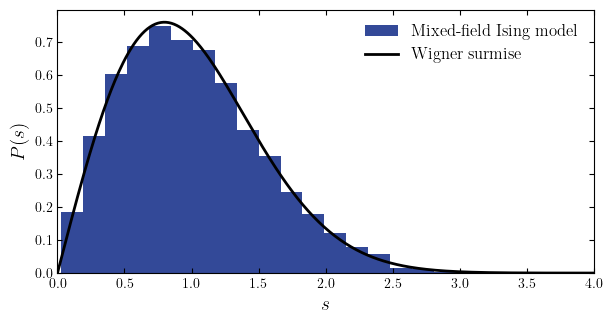

In [6]:
#Plot the level spacing statistics and the Wigner surmise

fig,ax = plt.subplots(figsize=[6.9185, 3.4207])

#Plot histogram from spectrum
n_bins = 20
ax.hist(s, bins = n_bins, 
        density = True,color='C0',alpha=.8,zorder=0,label=r'Mixed-field Ising model')

#Plot Wigner surmise
s_GOE = np.arange(0.,5.,0.01)
ax.plot(s_GOE,0.5*np.pi*s_GOE*np.exp(-0.25*np.pi*s_GOE**2),
        color='k',linewidth=2,zorder=1,label=r'Wigner surmise')

ax.legend()
ax.set_xlim(0.,4.)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$P(s)$')
plt.show()

### Check relaxation to equilibrium

In the following we select a generic basis state to be the initial state, time evolve the system, and calculate the dynamics of the spin magnetization along the $z$ direction, $\hat{O} = \sum_{j=1}^L \sigma_j^z\,.$

In [7]:
#Define initial state
psi_init = np.zeros(basis.Ns)
psi_init[-1] = 1.

In [8]:
#Define observable
J_z = [[1./np.sqrt(L),i] for i in range(L)]

#Static and dynamic lists
static = [["z",J_z]]
dynamic=[]

#Compute the observable
S_z = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [9]:
#Time range for dynamics
times = np.linspace(0.0,20.0,401)

#Time evolve initial state under H
psi_t = H_Ising.evolve(psi_init,0.0,times)

#Time evolve observable
Obs_time = obs_vs_time(psi_t,times,dict(S_z = S_z))

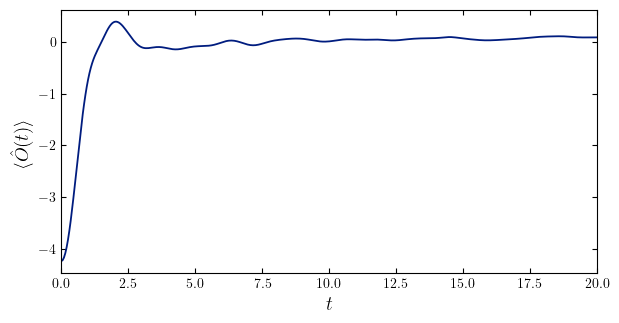

In [10]:
#Plot dynamics of observable
fig,ax = plt.subplots(figsize=[6.9185, 3.4207])
ax.plot(times,Obs_time['S_z'].real)
ax.set_xlim([0.,max(times)])
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle \hat{O}(t) \rangle$')
plt.savefig('relaxation.pdf',bbox_inches='tight')
plt.show()

### Check predictions from ETH

The Eigenstate Thermalization Hypothesis predicts that the matrix elements of an observable in the eigenbasis of the Hamiltonian can be described by the ansatz

$$O_{mn} = \overline{O(E)} \delta_{mn} + e^{-S(\overline{E})/2} f_O(E,\omega)R_{mn},$$

with $\overline{O(E)}$ the microcanonical expectation value and $f_O(E,\omega)$ smooth functions of the average energy $E=(E_m+E_n)/2$ and the energy difference $\omega = E_m-E_n$, and $R_{mn}$ Gaussian variables with zero mean and unit variance. In the following, we check this ansatz numerically for both the diagonal and off-diagonal matrix elements.

In [16]:
#Construct basis, Hamiltonian, and observable for different system sizes L=10,14,18
L = 10
basis = spin_basis_1d(L,pauli=True,pblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[J,i,(i+1) % L] for i in range(L)] # PBC
J_z = [[h_z,i] for i in range(L)]
J_x = [[h_x,i] for i in range(L)]

#Static and dynamic lists
static = [["zz",J_zz],["z",J_z],["x",J_x]]
dynamic = []

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
[E_10,V_10] = H_Ising.eigh()

#Define observable
#J_z = [[1./L,i] for i in range(L)]
#static = [["z",J_z]]
#dynamic=[]

#Define observable
J_xx = [[1./L,i,(i+1) % L] for i in range(L)] # PBC
static = [["xx",J_xx]]
dynamic=[]

#Compute the observable
Obs_10 = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [17]:
#Construct basis, Hamiltonian, and observable for different system sizes
L = 14
basis = spin_basis_1d(L,pauli=True,pblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[J,i,(i+1) % L] for i in range(L)] # PBC
J_z = [[h_z,i] for i in range(L)]
J_x = [[h_x,i] for i in range(L)]

#Static and dynamic lists
static = [["zz",J_zz],["z",J_z],["x",J_x]]
dynamic = []

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
[E_14,V_14] = H_Ising.eigh()

#Define observable
#J_z = [[1./L,i] for i in range(L)]
#static = [["z",J_z]]
#dynamic=[]

#Define observable
J_xx = [[1./L,i,(i+1) % L] for i in range(L)] # PBC
static = [["xx",J_xx]]
dynamic=[]

#Compute the observable
Obs_14 = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [18]:
#Construct basis, Hamiltonian, and observable for different system sizes
L = 18
basis = spin_basis_1d(L,pauli=True,pblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[J,i,(i+1) % L] for i in range(L)] # PBC
J_z = [[h_z,i] for i in range(L)]
J_x = [[h_x,i] for i in range(L)]

#Static and dynamic lists
static = [["zz",J_zz],["z",J_z],["x",J_x]]
dynamic = []

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
[E_18,V_18] = H_Ising.eigh()

#Define observable
#J_z = [[1./L,i] for i in range(L)]
#static = [["z",J_z]]
#dynamic=[]

#Define observable
J_xx = [[1./L,i,(i+1) % L] for i in range(L)] # PBC
static = [["xx",J_xx]]
dynamic=[]

#Compute the observable
Obs_18 = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [19]:
#Calculate diagonal matrix elements
exp_diag_10 = np.zeros(len(E_10))
for n in range(len(E_10)):
    exp_diag_10[n] = Obs_10.expt_value(V_10[:,n])

exp_diag_14 = np.zeros(len(E_14))
for n in range(len(E_14)):
    exp_diag_14[n] = Obs_14.expt_value(V_14[:,n])
    
exp_diag_18 = np.zeros(len(E_18))
for n in range(len(E_18)):
    exp_diag_18[n] = Obs_18.expt_value(V_18[:,n])

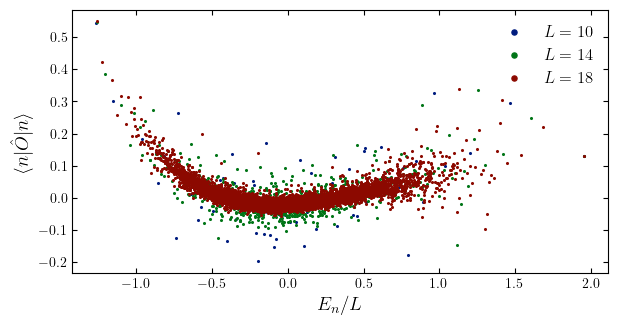

In [20]:
#Plot the diagonal matrix elements as a function of eigenstate energy
fig,ax = plt.subplots()
ax.scatter(E_10/10,exp_diag_10,color='C0',label=r'$L=10$',s=1.5)
ax.scatter(E_14/14,exp_diag_14,color='C1',label=r'$L=14$',s=1.5)
ax.scatter(E_18/18,exp_diag_18,color='C2',label=r'$L=18$',s=1.5)
ax.set_xlabel(r'$E_n/L$')
ax.set_ylabel(r'$\langle n |\hat{O} | n\rangle$')
ax.legend(markerscale=3)
plt.savefig('ETH_diagonal.png',bbox_inches='tight',dpi=400)
plt.show()

In [21]:
#Calculate the off-diagonal matrix elements as a function of omega for a fixed energy window
omega_mn = []
obs_mn = []
E_mn = []
for m,E_m in enumerate(E_18):
    for n,E_n in enumerate(E_18):
        if (m!=n and np.abs(E_m+E_n)<.1):
                omega = E_m - E_n
                O_mn = Obs_18.matrix_ele(V_18[:,m],V_18[:,n])
                omega_mn.append(omega)
                obs_mn.append(O_mn)
                E_mn.append(0.5*(E_m+E_n))
            
#Get envelope
omega_args = np.argsort(omega_mn)
d_omega = 0.5
omega_range = np.arange(-30,30+d_omega,d_omega)
avg_abs_range = np.zeros(len(omega_range))
avg_sq_range = np.zeros(len(omega_range))
n_range = np.zeros(len(omega_range))

for i, omega_i in enumerate(omega_mn):
    ind = np.argmin(np.abs(omega_range-omega_i))
    avg_abs_range[ind] += np.abs(obs_mn[i])
    avg_sq_range[ind] += np.abs(obs_mn[i])**2
    n_range[ind] += 1.

#Envelope function
f_obs_2 = avg_sq_range/n_range

#Characterizing Gaussian variables
avg_abs_range = avg_abs_range / n_range
avg_sq_range = avg_sq_range / n_range
fluc_range = avg_sq_range / avg_abs_range**2

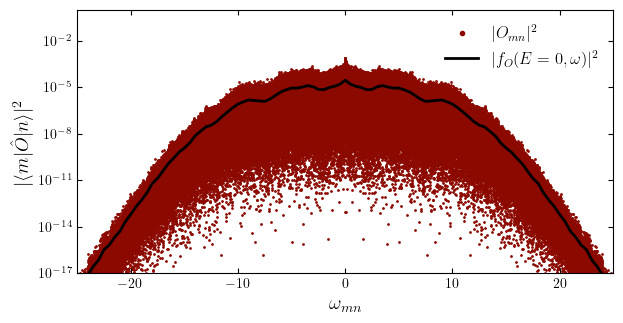

In [22]:
#Plot off-diagonal matrix elements as function of frequency and plot envelope
fig,ax = plt.subplots()
ax.scatter(omega_mn,np.abs(obs_mn)**2,color='C2',s=1.,label=r'$|O_{mn}|^2$')
ax.set_xlabel(r'$\omega_{mn}$')
ax.set_ylabel(r'$|\langle m |\hat{O} | n\rangle|^2$',zorder=0)
ax.plot(omega_range,f_obs_2,color='k',zorder=1,linewidth=2.,label=r'$|f_O(E=0,\omega)|^2$')
ax.set_yscale("log")
ax.set_ylim(1e-17,1.)
ax.set_xlim(-25,25)
ax.legend(markerscale=3)
plt.savefig('ETH_offdiagonal.png',bbox_inches='tight',dpi=400)
plt.show()

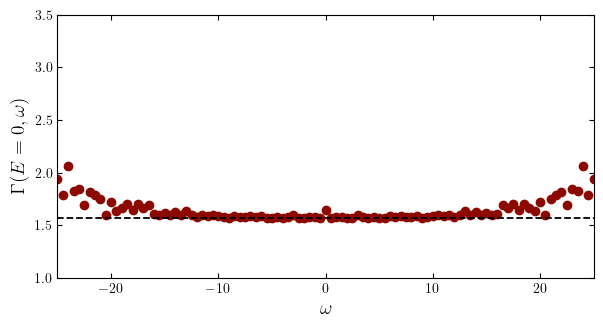

In [23]:
#Plot parameter characterizing fluctuations as function of energy
fig,ax = plt.subplots()
ax.scatter(omega_range,fluc_range,color='C2',zorder=1)
ax.axhline(0.5*np.pi,linestyle='--',color='k')
ax.set_xlim(-25,25)
ax.set_ylim(1.,3.5)
ax.set_ylabel(r'$\Gamma(E=0,\omega)$')
ax.set_xlabel(r'$\omega$')
plt.savefig('ETH_fluctuations.png',bbox_inches='tight',dpi=400)
plt.show()

### Level repulsion

In [20]:
###Define model parameters
L = 14 # system size
J = 1. # nearest-neighbour interactions
h_x = 0.9045 # transverse field
h_z = 0.809 # longitudinal field

basis = spin_basis_1d(L,pauli=True,pblock=1,kblock=0)

#Define operators with PBC using site-coupling lists
J_zz = [[J,i,(i+1) % L] for i in range(L)] # PBC
J_z = [[h_z,i] for i in range(L)]
J_x = [[h_x,i] for i in range(L)]


#Static and dynamic lists
static = [["zz",J_zz],["x",J_x]]

#Variable parameter
def ramp(t):
    return t

ramp_args=[]
dynamic =[["z",J_z,ramp,ramp_args]]

#Compute the Hamiltonian
H_Ising = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)

In [21]:
#Calculate full eigenspectrum at various times/parameters
dim = basis.Ns
t_range = np.arange(0,1,0.001)

E_range = np.zeros([len(t_range),dim])

for i, t_i in enumerate(t_range):
    E_range[i] = H_Ising.eigvalsh(time=t_i)

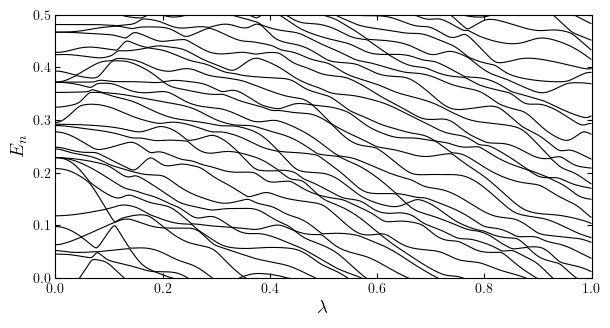

In [23]:
#Plot full eigenspectrum as function of parameter
fig,ax = plt.subplots()
for i in range(dim):
    ax.plot(t_range,E_range[:,i],'k',linewidth=0.8)
ax.set_ylabel(r'$E_n$')
ax.set_xlabel(r'$\lambda$')
ax.set_ylim(0.,.5)
ax.set_xlim(0.,1.)
plt.savefig('levelrepulsion.pdf',bbox_inches='tight')
plt.show()